## Step 1: Load the CFPB complaint dataset

In [1]:
import pandas as pd

df = pd.read_csv("../data/raw/complaints.csv")
print(df.shape)
df.head()

C:\Users\Dell\AppData\Local\Temp\ipykernel_24116\3275423424.py:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/raw/complaints.csv")


(9609797, 18)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689
3,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195690
4,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Experian Information Solutions Inc.,IL,60628,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195692


## Step 2: Basic data inspection
### 2.1 Check missing values

In [2]:
df.isnull().sum().sort_values(ascending=False)

Tags                            8981029
Consumer disputed?              8841498
Consumer complaint narrative    6629041
Company public response         4770207
Consumer consent provided?      1649561
Sub-issue                        839522
Sub-product                      235295
State                             54516
ZIP code                          30228
Company response to consumer         20
Issue                                 6
Date received                         0
Product                               0
Company                               0
Date sent to company                  0
Submitted via                         0
Timely response?                      0
Complaint ID                          0
dtype: int64

## 2.2 Explore product distribution

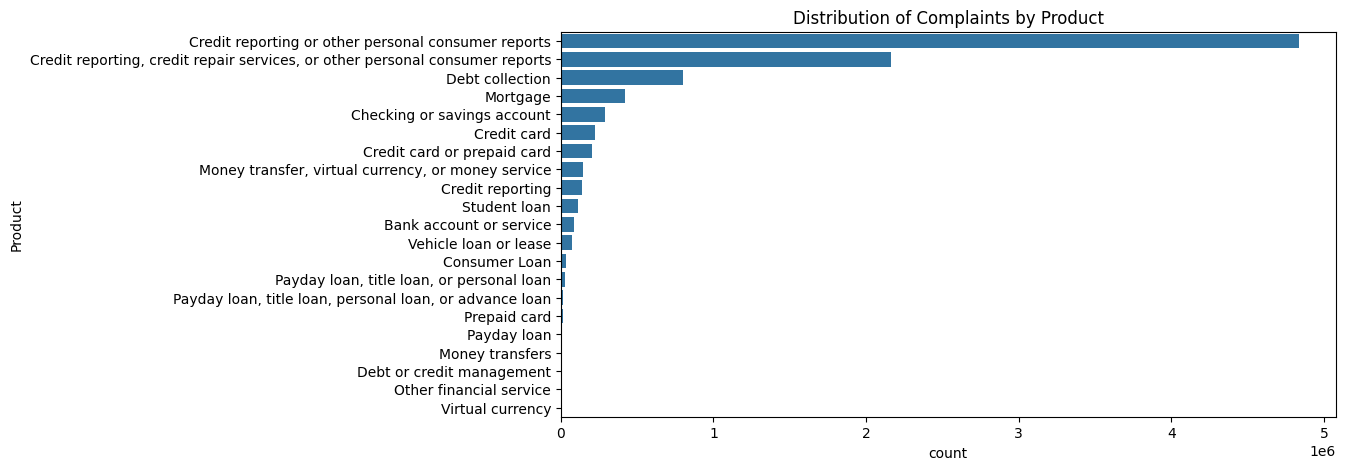

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.countplot(
    data=df,
    y="Product",
    order=df["Product"].value_counts().index
)
plt.title("Distribution of Complaints by Product")
plt.show()

## Step 3: Analyze complaint length 

### Create a word count column:

In [4]:
df["complaint_length"] = df["Consumer complaint narrative"].astype(str).apply(
    lambda x: len(x.split())
)

### Visualize it

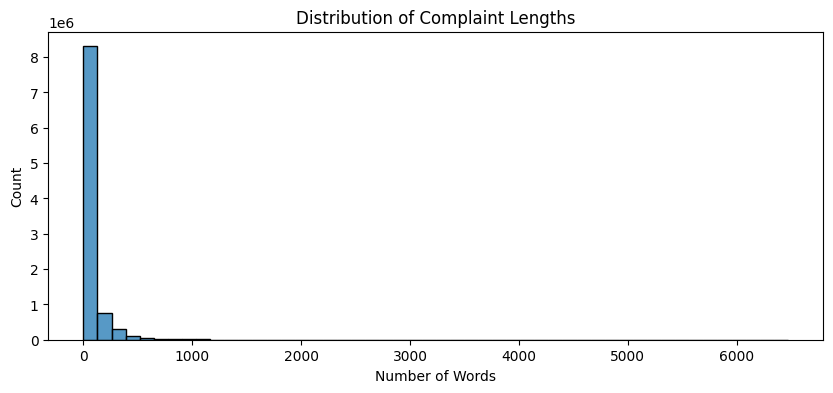

In [5]:
plt.figure(figsize=(10,4))
sns.histplot(df["complaint_length"], bins=50)
plt.title("Distribution of Complaint Lengths")
plt.xlabel("Number of Words")
plt.show()

In [6]:
df["complaint_length"].describe()

count    9.609797e+06
mean     5.515649e+01
std      1.495169e+02
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      5.000000e+01
max      6.469000e+03
Name: complaint_length, dtype: float64

### Complaint Volume Over Time
#### This helps identify trends, spikes, or seasonality in customer complaints.

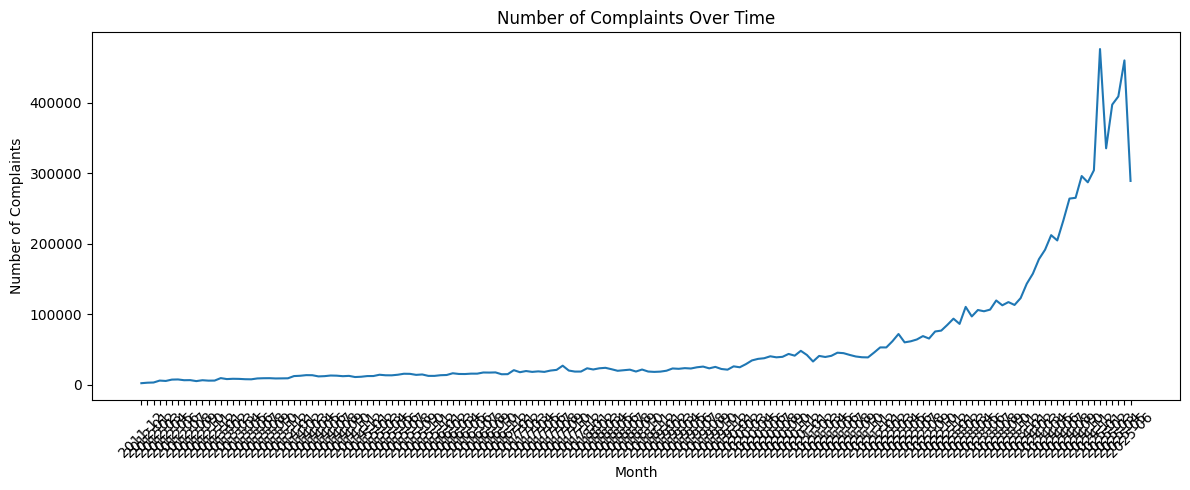

In [7]:
df["Date received"] = pd.to_datetime(df["Date received"], errors="coerce")

complaints_over_time = (
    df.groupby(df["Date received"].dt.to_period("M"))
      .size()
      .reset_index(name="count")
)

plt.figure(figsize=(12,5))
plt.plot(complaints_over_time["Date received"].astype(str),
         complaints_over_time["count"])
plt.xticks(rotation=45)
plt.title("Number of Complaints Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Complaints")
plt.tight_layout()
plt.show()

## Step 5: Filter to project-specific scope

### Filter to only the required product categories:

In [9]:
target_products = [
    "Credit card",
    "Personal loan",
    "Savings account",
    "Money transfers"
]

filtered_df = df[df["Product"].isin(target_products)]

### Complaint Length by Product Category

#### This shows whether certain products receive more detailed or complex complaints.

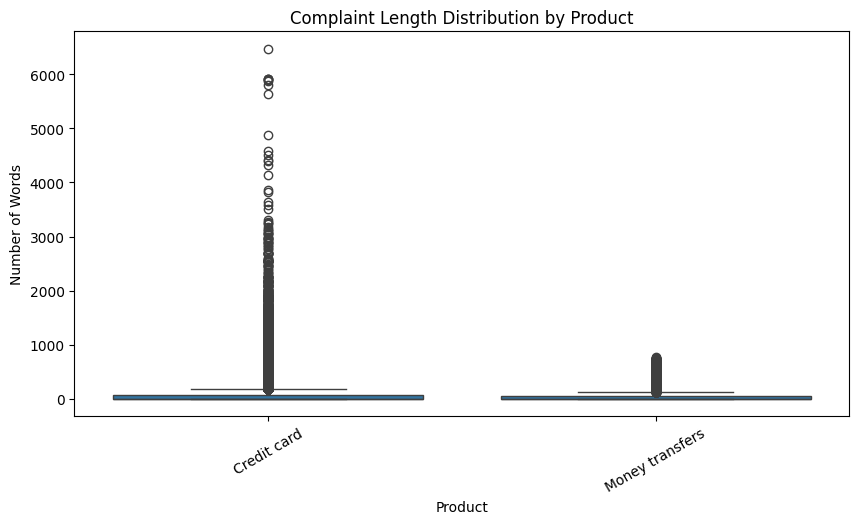

In [10]:
plt.figure(figsize=(10,5))
sns.boxplot(
    data=filtered_df,
    x="Product",
    y="complaint_length"
)
plt.xticks(rotation=30)
plt.title("Complaint Length Distribution by Product")
plt.ylabel("Number of Words")
plt.show()

### Complaints per Product

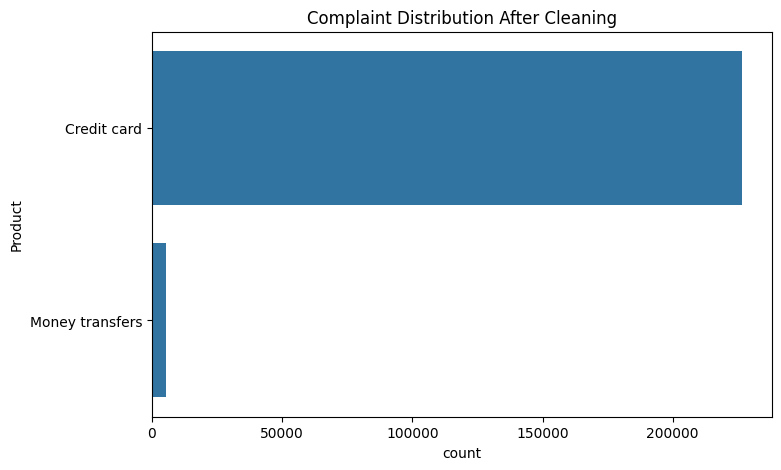

In [13]:
plt.figure(figsize=(8,5))
sns.countplot(
    data=filtered_df,
    y="Product",
    order=filtered_df["Product"].value_counts().index
)
plt.title("Complaint Distribution After Cleaning")
plt.show()

### Remove empty or meaningless narratives:

In [14]:
filtered_df = filtered_df[
    filtered_df["Consumer complaint narrative"].notna() &
    (filtered_df["Consumer complaint narrative"].str.strip() != "")
]

In [15]:
filtered_df.shape

(82164, 19)

## Step 5: Clean the complaint text

### Define a simple cleaning function:

In [16]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [18]:
import re
filtered_df["clean_complaint"] = filtered_df["Consumer complaint narrative"].apply(clean_text)

C:\Users\Dell\AppData\Local\Temp\ipykernel_24116\1988828763.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["clean_complaint"] = filtered_df["Consumer complaint narrative"].apply(clean_text)


### Most Frequent Words in Complaints 

#### This gives a quick sense of recurring themes before moving to embeddings.

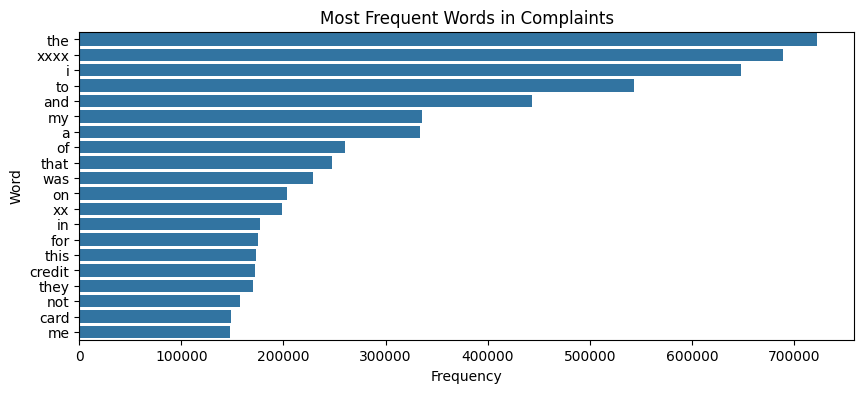

In [19]:
from collections import Counter

all_words = " ".join(filtered_df["clean_complaint"]).split()
common_words = Counter(all_words).most_common(20)

words, counts = zip(*common_words)

plt.figure(figsize=(10,4))
sns.barplot(x=list(counts), y=list(words))
plt.title("Most Frequent Words in Complaints")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

## Step 7: Save the cleaned dataset

In [20]:
output_path = "../data/processed/filtered_complaints.csv"
filtered_df.to_csv(output_path, index=False)